# Задание

Планируется сделать приложение, в котором будем по всевозможным признаками определять растения. Изначально зададим всевозможные модели для распознавания, а потом попробуем привязать к приложению (если успеем). Приложением занимается Даша Ефимова, я же попробую настроить модели.

## План

1. Для начала познакомимся с тематикой и попробуем сделать простенькую модель для определния растения по каким-то атрибутам (по внешнему виду). Планируется, что Даша Ефимова еще сделает что-то подобное, только с жесткой привязкой к БД. То есть просто задавание атрибутов и запрос к БД. Я же попробую сделать одной моделью. Для начала в качестве эксперимента возьму популярному и уже христоматийному тему набора [Ирисов](https://en.wikipedia.org/wiki/Iris_flower_data_set) (знаменитая задача классификации Ирисов Фишера). Сошлемся как на [задание](https://www.kaggle.com/uciml/iris) с Kaggle. В этой задачке посмотрим как какие-нибудь классификаторы (логистическая регрессия, svm и другие), так и обучение без учителя (попробуем кластеризовать данные на уже известное количество кластеров, а затем и попробуем как-нибудь визуализировать данные, посредтсовм алгоритмов уменьшения пространства). Обязательно оценим отечетсвенную новую библиотеку градиентного бустинга от Яндекса [CatBoost](https://tech.yandex.ru/catboost/), которая, [как обещают](https://catboost.yandex/#benchmark) выигрывает у своих аналогов. Мы же сравним с обычными агоритмами.
1. Затем попробуем усложнить задачу. Скажем, попробовать классифицировать растения по картинкам. Датасет возьмем с другой [задачки](https://www.kaggle.com/olgabelitskaya/the-dataset-of-flower-images/data) Kaggle, где есть набор где-то из 210 картинок и 10 классов цветов (скажем прямо, что это достаточно маленькие выборки, но посмотрим, что выйдет). Для этого, скорее всего раннние алгоритмы вряд ли подойдут из-за сложнсти данных (большое количество разных признаков, для которых надо было бы кучу данных для нормального обучения), поэтому попробуем использовать свертовачные нейронные сети ([Convolutional Neural Networks](http://cs231n.github.io/convolutional-networks/)), которые как раз и испольуют для распознавания картинов. Например, в задачке определния [кошек и собак](https://www.kaggle.com/c/dogs-vs-cats/rules) задачки Kaggle именно cnn показал очень неплохой [результат](http://www.subsubroutine.com/sub-subroutine/2016/9/30/cats-and-dogs-and-convolutional-neural-networks). Аналогично последней приведенной ссылке, я не буду писать нейронную суть, а попробую взять реадизацию от Google [TesorFlow](https://www.tensorflow.org/)
1. Если все пойдет хорошо, попробуем и привязать что-нибудь с другими растениями. Например, помогать грибникам определять, [можно ли кушать](https://www.kaggle.com/uciml/mushroom-classification/data) гриб.

# Iris Dataset
Как было уже отмечено выше, для начала рассмотрит датасет ирисов. Подгрузим сам датасет, а затем посмотрим, что за данные мы имеем.

## Первые четыре атрибута

In [49]:
from sklearn import datasets
import pandas as pd
import numpy as np
iris = datasets.load_iris() # Выгружаем датасет ирисов
# переводим из sklearn.DataSet в pd.DataFrame для удобства
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']], 
                     columns= iris['feature_names'] + ['target'])

In [4]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


Как видим, мы имеем четыре атрибута, которые задают характеристики ириса (длина/ширина чашелистника (sepal) и лепестка (petal)). Отдельно отметим, что все эти признаки являются числовыми, т.е. они могут свободно использоваться в линейных метрических моделях (скажем, при вычислении эвклидова расстояния между листками длиной в 5 и 6 сантиметров будет меньше, чем между 2 и 6, что и логично). Однако несмотря на то, что они уже являются числовыми, далеко не факт, что они не требуют дополнительной обработки. Разбросы значений в разных признаках могут сильно влиять на результат. Визуально (по первым пяти значениям, что мы видим выше), кажется, что ониразбросаны более-менее равномерно. Оценим это более точно.

In [5]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667,1.000000
std,0.828066,0.433594,1.764420,0.763161,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


Как видим, все признаки (рассматриваем сейчас первые четыре) разбросаны равномерно (вернее, можно выделить крайние, которые немного выше и ниже по значеням соответственно), но это кажется незначительным. Если будет выходить плохая модель, то для повышения точности можно будет попробоать отмасштабировать (нормализовать) значения признаков (обычным StandardScaler(), который вычтет из каждого среднее значение по признаку и разделит на стандартное отклонение). Это необходимо, потому что при больших значениях данные атрибуты будут иметь просто больший вес, а другие атрибуты почти игнорируются. В качестве примера обычно приводят сравнение датасетов, когда, скажем, у нас есть признак отвечающий за зарплату и количество детей. Возьмем в пример трех людей: а) з/п: 100 000; Детей: 0. б) з/п: 120 000; Детей: 5. в) з/п: 105 000; Детей: 4, то, казалось бы, больше всего тут похож б) и в) персонажи, однако обычная метрика даст другой результат, что как  раз и с тем, о чем мы говорили выше. Другим очень выжным требованием для успешного обучения вялется условие, чтоб данные подчинялись нормальному закону. Проверить это можно посредством scipy.stats.mstats.normaltest. В качестве примера посмотрим один из атрибутов.

In [6]:
import scipy
scipy.stats.mstats.normaltest(df['sepal width (cm)'])

NormaltestResult(statistic=3.5766421600696949, pvalue=0.16724071787237141)

Как видим, хи-квадрат (второй аргумент) показывает 0.16 Данное значение не очень велико, но бывают случаи куда и куда хуже. Для приведения к нормальному распределнию можно было бы попробовать прологарифмировать шкалу, например, чтоб выбросы стали менее заметными. Однако пока опустим это. 

## Target

Последний атрибут $target$ (про который мы еще не говорили) является как раз-таки маркером, отражающим, к какой категории относится данный цветок (отдельно взятая строка). Посмотрим, сколько значений принимает данный атрибут.

In [7]:
df['target'].value_counts(normalize=True)

2.0    0.333333
1.0    0.333333
0.0    0.333333
Name: target, dtype: float64

Как видим, в нашей выборке имеем три вида ирисов, причем все они встречаются равновероятно (по 50 на каждый вид (см. таблицу с описанием всех призакнв выше)), что очень благоприятно.  
После описания перейдем к обучению.

# Unsupervised Learning (часть 1)

Для начала рассмотрим один из видов обучения без учителя, а если быть точнее - уменьшение размерности ([Dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction)) Данную первую часть рассмотрим перед классическими моделями для обучения с учителем, чтоб сначала научиться как-то смотреть на результат классификации нашей модели. Конечно, мы будем получать и цифровые показатели оценки обучения, но хотелось бы и увидеть воочию, как мы обучаем. Суть алгоритмов уменьшения размерности кроется в самом названии. Есть попытаться кратко передать суть, то она прозвучит: попытаться увидеть наши d-мерные данные в n-мерном пространстве. Для человеческого глаза, как известно, приемлемым будет случай для n равным 2 или 3. В качестве алгоритмов уменьшения без учителя рассмотрим несколько самых популярных: PCA, MDS и t-SNE.
Не будем очень подробно останавливаться на каждом из них, но отразим хотя бы главные идеи этих алгоритмов.

## PCA

[PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) (англ. principal component analysis ) или просто [Метод главных компонент](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%B3%D0%BB%D0%B0%D0%B2%D0%BD%D1%8B%D1%85_%D0%BA%D0%BE%D0%BC%D0%BF%D0%BE%D0%BD%D0%B5%D0%BD%D1%82) - уменьшить размерность данных посредством проецирования данных в ортогональные проеции таким образом, чтоб терять наименьшее количество информации. В данном случае количеством потерянной информации считаеся как суммарное среднеквадратичное отклонение старых точек до проецированя к новым. Можно посмотреть на [эту завораживающую анимацию](https://i.stack.imgur.com/Q7HIP.gif), где в зависимости от разных прямых меняется расстояние от старых точек до новых (проекции на прямую). Фиолетовым обозначена идеальный случай (минимальное значение того функционала, что мы выделили выше). Вычисления достаточно простые: сначала вычисляем [ковариоционную матрицу](https://en.wikipedia.org/wiki/Covariance_matrix) (которая будет характеризовать зависимость случайных велечин друг от друга), потом [собственный вектор](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors) и соответсвующее ему [собственное значение](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors). Собственное значение и есть мера количества информации. Поэтому соритруем собственные числа, выбираем количество компонент (количество собственных чисел, если не визуализируют данные, то можно выбирать количество компонент по количесву потерянной информации, скажем, 90%) и затем можем путем выбора сооветсвующих векторов умножать значение нашей матрицы значений на эту матрицу собственных векторов ($W$), как и получае новые значения (проекции).    

Приведем небольшой пример работы.  
I. Для начала вычисляем ковариационную матрицу для входной матрицы значений и по ней собственные вектора со значениями

In [121]:
cor_mat = np.cov(iris.data.T)
print('Covariance matrix: \n%s' %np.cov(iris.data.T))
print()
eig_vals, eig_vecs = np.linalg.eig(cor_mat)
print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Covariance matrix: 
[[ 0.69 -0.04  1.27  0.52]
 [-0.04  0.19 -0.32 -0.12]
 [ 1.27 -0.32  3.11  1.3 ]
 [ 0.52 -0.12  1.3   0.58]]

Eigenvectors 
[[ 0.36 -0.66 -0.58  0.32]
 [-0.08 -0.73  0.6  -0.32]
 [ 0.86  0.18  0.07 -0.48]
 [ 0.36  0.07  0.55  0.75]]

Eigenvalues 
[ 4.22  0.24  0.08  0.02]


 II. Сортируем по собственному значению. Выбираем количество компонент (в данном случае 2) и получаем матрицу $W$

In [128]:
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort()
eig_pairs.reverse()
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print('val: {} arr: {}'.format(i[0], i[1]))
matrix_w = np.hstack((eig_pairs[0][1].reshape(4,1), 
                      eig_pairs[1][1].reshape(4,1)))
matrix_w

Eigenvalues in descending order:
val: 4.224840768320107 arr: [ 0.36 -0.08  0.86  0.36]
val: 0.242243571627515 arr: [-0.66 -0.73  0.18  0.07]
val: 0.07852390809415474 arr: [-0.58  0.6   0.07  0.55]
val: 0.023683027126001163 arr: [ 0.32 -0.32 -0.48  0.75]


array([[ 0.36, -0.66],
       [-0.08, -0.73],
       [ 0.86,  0.18],
       [ 0.36,  0.07]])

III. Получаем новые значения-проекции (в данном случае покажем только два новых значения)

In [131]:
Y = iris.data.dot(matrix_w)
Y[0:2]

array([[ 2.83, -5.64],
       [ 2.8 , -5.15]])

Отметим, что на самом деле задачка отлично решается посредством сингулярного разложения (обязательным условием является то, чот данные [нормализованы](https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca?answertab=oldest#tab-top)!). Как известна, любую матрицу можно представить как произведение трех других. Обычно их обозначаю $U$$\sum$$V^*$ Где $V^*$- самая правая матрица (как известно, при перемножении матриц важно соблюдать их положение), так называемая матрица поворота (аналог из линейной алгебры). В нашем случае, который мы рассматривали это матрица, которая отвечает за поворот прямой. Вторая матрица - $\sum$, диагональная матрица, где на главное диагонали располагаются как раз-таки те дельты, которые мы раннее приняли за суммарное среднеквадратическое отклонение старых точек к новым к относительно даннной компоненты (компоненты все нумеруются и составляют каждая свой новый уровень). Причем расставляются в порядке уменьшения этой дельты. Поэтому задачка значитально упрощается. Достаточн все начальное пространство (представляем в виде матрица) разложить на три матрица. Выбрать количество главных компонент (что будет составлять количество строк тех самых матриц) и перемножить между собой. Мы получим новые точки. Причем однозначно сможем определить эквивалент количества потерянной информации (как раз-таки эти дельты). На практике так и применяется. Для сингулярного разложения можно использовать даже [SVD](https://en.wikipedia.org/wiki/Singular-value_decomposition) разложение, которое тоже реализовано в Питоне, а потом взять библиотечный вариант PCA и сравнить результаты. Они если и недолжны отличаться, то хотя бы будут очень похожи. Подброный разбор можно найти [тут](http://sebastianraschka.com/Articles/2014_pca_step_by_step.html#eig_vec) и [тут даже для нашей задачи](https://plot.ly/ipython-notebooks/principal-component-analysis/)

Теперь построим отображение для трехмерного случая.

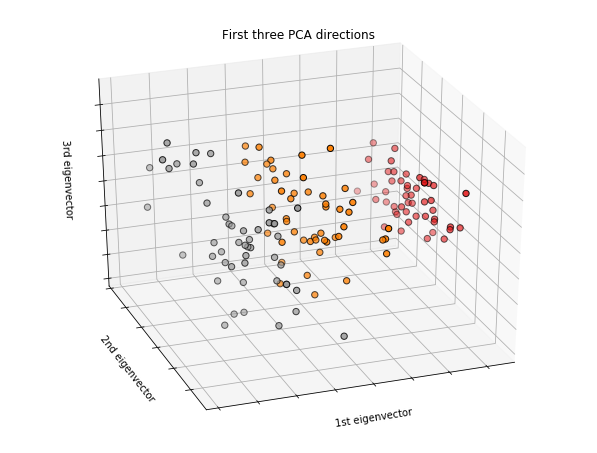

In [2]:
# урезаем код. Ниже будет рассмотрен более компактный случай

Аналогично построим для двумерного случая. Отметим, что двумерный случаем будет какая-то из плоскостей трехмерного пространства, которая наилучшим образом сохраняет положение точек.

Populating the interactive namespace from numpy and matplotlib


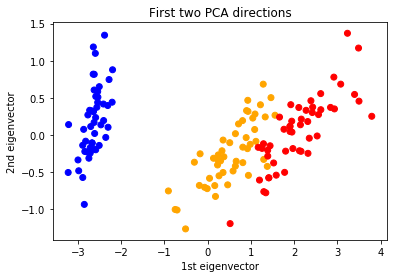

In [135]:
from sklearn.decomposition import PCA
iris = datasets.load_iris()
y = iris.target
X_reduced = PCA(n_components=2).fit_transform(iris.data)
%pylab inline
import matplotlib.pyplot as plt
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], \
            c=df['target'].map({0: 'blue', 1: 'orange', 2: 'red'}));
plt.title('First two PCA directions')
plt.xlabel('1st eigenvector')
plt.ylabel('2nd eigenvector')

## t-SNE

t-SNE (англ. [t-distributed stochastic neighbor embedding](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)) - является улучшенной версией аналогичного похожего алгоритма SNE - случайное отображение по соседям, если уж дословно, но в t-SNE есть ряд улучшений, одно из которых - использование t-распределяни (скажем, для определения принадлежности к одной выборке).  
Данный [метод](http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) предложил один из чародеей нейронных сетей [Д. Хитон](https://en.wikipedia.org/wiki/Geoffrey_Hinton), где в [официальном FAQ](https://lvdmaaten.github.io/tsne/) пишет:  
>  "... As a result, it often works better if you increase the degrees of freedom of the t-distribution when embedding into thirty dimensions ..."  

То есть можно применять данный алгорритм и для отображения на многомерные пространтсва, но тогда надо повышать степень свободы t-Распределения. Как я понимаю, тут идет речь про проблему скученности (в оригинале – crowding problem).  
Кажется, если строго все объяснять, то данное домашнее задание получится слишком перегруженной, поэтому будем стараться указывать только основные мысли и идеи алгоритмов. При необходимости сделать все более подробно.  
Попытаемся понять суть данного алгоритма. Основная идея заключается в поиске таких двух признаков для всех данных, которые позволили бы наилучшим образом описать все данные в том смысле, чтоб сохранялись соотношения по расстоянию между конкретными точками данных. То есть, если в d-мерном пространстве две точки лежат рядом с друг другом, то и в двумерном, они будут лежать рядом. Хорошим примером и является уменьшения размерности из трехмерного в двумерное: т.е. если изначально наши все точки представлены в каком-то кубе, и мы пытаемся найти одну такую плоскость, которая наилучшим образом сохраняет это положение.
    Для понимая же работы самого алгоритма для можно привести физическую аналогию: все точки соединены пружинами, и делается предположение, что через какое-то время благодаря результирующей силе (которая в данном случае является аналогом градиента, который минимизирует функцию потерь) ближние точки будут стягиваться, а дальние - отталкиваться и система в итоге придет в равновесие.  
    Сравнива PCA и t-SNE [предпочтнее стоит все-таки отдавать](https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b) t-SNE. Отметим, что эти алгоритмы можно с успехом [рассматривать и в паре](https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b).  
    

In [50]:
%%time
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
tsne_representation = tsne.fit_transform(df)

CPU times: user 1.3 s, sys: 164 ms, total: 1.47 s
Wall time: 1.51 s


Populating the interactive namespace from numpy and matplotlib


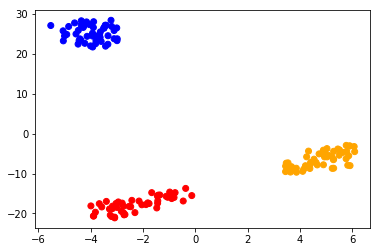

In [51]:
import matplotlib.pyplot as plt

%pylab inline
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], \
            c=df['target'].map({0: 'blue', 1: 'orange', 2: 'red'}));

## MDS

MDS (англ. [Multidimensional scaling](https://en.wikipedia.org/wiki/Multidimensional_scaling)) - метод многомерного шкалирования, который просто минимизирует квадраты отклонения между попарными расстояния новых точек и их проекций в низкоразмерном пространстве. Минусом данного метода является то, что в него очень сложно добавить новые данные.  
Получаем функционал 
$$\sum_{i\neq j}^{l} (\rho(x_i, x_j)-\rho(z_i, z_j))^2 \rightarrow \min_{z_1,\dots z_l}$$, где $x_i \in R^d$ - исходные объекты, а $z_i \in 	R^d$, $2 \leqslant d \leqslant 3$ - их низкоращмерные проекции.  
 Более детальный анализ оставим. Однако приведем всевозможных источники для доп. ([основной](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture12-unsupervised.pdf)) информации и для [сравнения методов](http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py).

Populating the interactive namespace from numpy and matplotlib
CPU times: user 248 ms, sys: 488 ms, total: 736 ms
Wall time: 186 ms


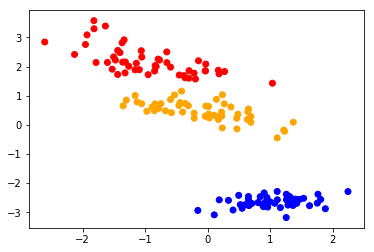

In [136]:
%%time
%pylab inline
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
mds = MDS(n_components=2, random_state=0)
mds_representation = mds.fit_transform(df)
plt.scatter(mds_representation[:, 0], mds_representation[:, 1], \
            c=df['target'].map({0: 'blue', 1: 'orange', 2: 'red'}));

## Вывод

Для нашей задачи для визуализации будет использовать t-SNE, т.к. он показал наилучший результат (наибольшее расстояние между кластерами, что он выделил).

# Supervised Learning

Теперь рассмотрим задачи для обучения с учителем. Т.е. мы будем обучать модель по тем маркерам, что имеем (столбец $target$) , а затем по новым входным данным прогнозировать (классифицировать). Для этого из всего датасета выделим обучающую выборку и  отложенную (тестовую). Очень важно, чтоб тестовые значения выбирались не простым образом, как, сначала первые 70% данных, а потом остальные тридцать, а случайным образом. Для решения данной проблемы будем использовать train_test_split(...), который и решает данную проблему, выбираем наборы для обучения и теста максимально непредвзято.

Прежде чем начнем непосредственно обучать модели, обозначим то, как будем оценивать наши модели. Кроме визуального анализа (будем строить отображения t-SNE), будем использовать численные метрики для оценки. 

## Численные оценки качества

### Accuracy

Данная метрика просто отражает количество тех случаев, когда классификатор принял правильное решение относительно всех попыток. 
$$Accuracy = \dfrac{Right}{All}$$  
Данную оценку можно использовать, но если классы неравнозначные, то лучше от нее стоит отказаться. Часто бывает, что тот класс, что мы ищем, в процентом соотношении составляет всего несколько процентов, т.е. даже слепое предсказание того, что данные не пренадлежат к этому классу покажет очень высокий показатель. Например, у нас есть класс, где 99% класс {1}, а 1% - {-1}. Слепое предсказание {1} покажет точность в 99%, хотя на самом деле мы ни разу не детектируем наш класс, который мы ищем.

### Precision and Recall

Точность и полнота (Precision and Recall) помогает решить ту проблему соотношения признаков, что мы выделили в $Accuracy$.
Построим $Confusion Matrix$ (из статистика данная таблица известа для составления ошибок разного рода), чтоб объяснить данные показатели качества. 
![Confusion Matrix](https://i.stack.imgur.com/ysM0Z.png)
Откуда получаем
$$Precision = \dfrac{TP}{TP+FP}$$  
$$Recall = \dfrac{TP}{TP+FN}$$  
Т.е. в данном случае точность ($Precision$) отражает именно процент правильно принятых решения, когда решение вообще принималось относительно класса, которые ищем, а полнота ($Recall$) отражает процентное соотношение содержание правильных предсказаний относительно всего количества, что мы должно были бы найти. 

Однако в данном случае мы рассматриваем задачу бинарное классификации (всего два класса), в нашем же случае класса три. Расширить $Confusion Matrix$ для многомерного случая очень просто, а точность для $i$-го класса будет считаться как отношение $i$-го значения на главное диагонали к значанию в $i$-ом столбце. Аналогично для  полноты, только столбец заменяем строчкой. Отметим, что обычно, для того, чтоб не возникали нули, вводят поправочные свободные коэффициенты в числителе и знаменателе.

### F-measure

Часто полнота и точность (см. предыдущий пункт) являются обратно зависимыми велечинами, то есть с увеличением одной, будет падать другая. Для того, чтоб определить какой-то баланс между этими велечинами, оценивают среднее гармоническое между ними (т.к. эта оценка чувствительна к нулям, если хотя бы одна из них стремится к нулю, то и данные меры будет нулевой)
$$F=2\dfrac{Recall * Precision}{Recall+Precision}$$

Данную меру еще называют еще $F1$ мерой. Для того, чтоб придать какой-то вес одной из велечин, можно задать параметр $\beta$ (для $F1$ меры $\beta=1$), который будет отвечать вес при точности.

После задания оценок для классификаторов перейдем к обучению моделей.

## Модели классификации

### Логистическая регрессия



Итак, первый алгоритм, который мы рассмтрим будет [логистичекая регрессия](https://en.wikipedia.org/wiki/Logistic_regression). Отношения к как таковой регресси в классическом понимании как составление тренда или какое-то экстраполирование данная модель не имеет никакого отношения. Название такое сложилось исторически. Опишем вкратце как она обучается. Итак начнем с описания для бинарной классификации (имеется два признака $x_1$, $x_2$), которцю затем обобщим для многоклассового сучая ($x_1$, $\dots$ $x_d$). Итак, представим, что у нас есть какие-то два облака точек, которые необходимо разделить какой-то прямой (отметим и дальше будет заметно, что данный метод строит ленийные разделяющие поверхности). Каждая точка имеет свои координаты ($x_1^i$, $x_2^i$). В таком случае прямую можно представить в виде вектора $w$, значения которой получаются после скалярного произведения $w$ на $x_1$ и $x_2$, смещение же задается отдельно как $w_0$, можно и ввести его отдельно, тогда вектор $w$ будет из себя представлять $w1$...$w0$, а $x: (-1, x_1, x_2)$. Значение при $w_0$ задает смещение (threshold). Теперь необходимо задать функционал, относительно которого считаются значения ветора $w$. Для этого задаются всевозможные функции потерь, которые необходимо минимизировать. Cамым простым случаем можно считать вариант, когда мы подсчитываем количество неправильных классификаций. Однако тут сразу видна основная проблема: тогда выйдет, что наша функция будет дискретна. Поэтому для ухода от этого пагубного фактора используют другой функционал. Для начала рассмтотрим, что из себя представляет скалярное произведение произвольной точки $x_i$ на вектор $w$, а именно, он характеризует, и это строго доказывается, расстояние точки до нашей разделяющей прямой (перпендикуляр). Это расстояние обычно обозначают буквой $M$ (Margin). Теперь посмотрим, как мы можем детектировать отношение к одному или другому классу. Если прямая разделяет два класса, то выходит, что один класс просто выше прямой (на языке линейной алгебры значение в точке больше проекции этой точке на прямую), а другой ниже. Однако обозначим один класс положиельными единицами (что выше), а другой отрицательными. Тогда выходит, что расстояния $M$ буду отрицательными для того класса, что ниже и положительными для того, что выше, но при перемножении $M$ на соответсвующйи маркер мы получаем аналог модуля расстояния. Теперь перейдем вплотную к составлению функционала. Идельный случай, когда бы мы все правильные классификации никак не трогали (или бы давали отрицательный отклик функции потерь), а неправильные случае как-то штрафовали. Можно себе представить ступеньку, где по оси абсцисс откладываем как раз-таки наши расстояние $M$, а по оси ординат величину штрафа, тогда мы бы штравовали только неправильные случаи. Но такая функция вышла бы не дифференцируема (на всей области), поэтому тут используют так называемую логистическую функцию потерь ([log-loss](http://wiki.fast.ai/index.php/Log_Loss)). Она из себя представляет: log 1/(1+exp(-M)). () Отсюда видно, что те точки, что находятся далеко от разделяющей прямой и классифируются правильно не будут штрафоваться, а те, что близки к ней или неправильно классифицируются - штрафуются. Логарифм позволяет сгладить тяжелые концы, поэтому наша функция не так будет чувствительна к выбросам. Именно этот функционал и опмтимизируется. Для находждения минимума функции потерь (просчитываем сумму функции потерь для каждой точки) обычно используются [градиентный спуск](https://en.wikipedia.org/wiki/Gradient_descent). Для справки отметим, что зачастую в алгоритмах применяется [случайный](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) (stohastic) градиентный спуск, где значение градиента считается только для одной из координат для одной итерации.

Попробуем обучить модель. Для того, чтобы первично оценить модель, посмотрим, какие цифры она покажет на кросс-валидаци.

### CV

CV ([cross-validation - скользящий контроль](http://www.machinelearning.ru/wiki/index.php?title=%D0%A1%D0%BA%D0%BE%D0%BB%D1%8C%D0%B7%D1%8F%D1%89%D0%B8%D0%B9_%D0%BA%D0%BE%D0%BD%D1%82%D1%80%D0%BE%D0%BB%D1%8C)) - процедура эмпирического оценивания обобщающей способности алгоритмов, обучаемых по прецедентам. Как работает данный метод. Сначала фиксируются какие-то части обучающей и тестовой выборок (деление общих данных). Проводится обучение по соответсвующей части выборки, а затем проверка по тестовой. Подводятся результаты по какой-то из мер оценки качества и повторяется для других частей всей выборки. Есть много разных подходов (complete CV (всевозможные случаи (оченсь сложно)), leave-one-out CV (убираем один (очень малая чувствтельность)), hold-out CV (обычное деление на отложенную выборку, что и так реудизуем), q-fold и др.), но мы будем использовать самый популярный q-fold, когда всю выборку делят на $q$ равных частей, и затем обучают по $q-1$ части и тестируют по отставшейся. Данную процедру провоят до тех пор, пока в тестовой части не побудут все фолды ($q$ блоки). Обычно выбираеют деление на 5 или 10 блоков, что доказывается статистически. Для уменьшения рассчетов, будем использовать кросс-валидацию с делением по 5.

In [76]:
from sklearn import linear_model, datasets
logreg = linear_model.LogisticRegression(C=1e5)
iris = load_iris()
np.mean(cross_val_score(logreg, iris.data, iris.target, cv=5))

0.95999999999999996

Среднее значение по кросс-валидации получилось .96 (считаем по $acurracy$ по-умолчанию), что очень хорошо. Уже сейчас можно говорить, что скорее всего эта модель покажет себя достойно.   
Теперь разделим выборку на тестовую и обучающую. (выделим треть на тест)

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=.33)

Обучаем модель аналогично тем параметрам, что мы обучали на первом этапе с кросс-валидацией. 

In [53]:
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(X_train, y_train)
y_predict = logreg.predict(X_test)

Благодаря t-SNE визуально оценим качество нашей модели.

In [54]:
%%time
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_representation = tsne.fit_transform(X_train)

CPU times: user 760 ms, sys: 116 ms, total: 876 ms
Wall time: 874 ms


Отдельно разукрасим предсказанную часть и реальную.

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


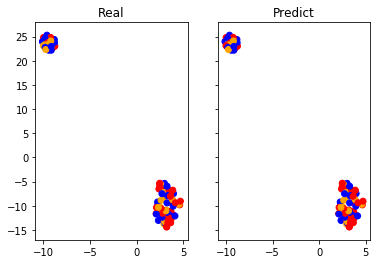

In [58]:
%pylab inline
dict_colors = {0:'blue', 1:'orange', 2:'red'}
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.set_title('Real')
ax1.scatter(tsne_representation[:, 0], tsne_representation[:, 1], \
            c=list(map(dict_colors.get, y_test)));

ax2.set_title('Predict')
ax2.scatter(tsne_representation[:, 0], tsne_representation[:, 1], \
            c=list(map(dict_colors.get, y_predict)));

Чисто визуально кажется, что модель отлично предсказывает классы. Теперь оценим эти в числах.  
  Для этого сначала составим матрицу ошибок ($Confusion Matrix$), а затем подсчитаем числовые оценки качества нашей модели, а именно: $precision$, $recall$, $f1$. Для этого напишем одну общую функцию для всех моделей. 

In [78]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass
       
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def fit_model_iris(model):
    model.fit(X_train, y_train) # обучаем модель (для всех одинак. разбиение)
    y_pred = model.predict(X_test) # предсказываем на тесте
    
    # строим матрицу ошибок
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

    # вычисляем точность, полноту и ф-меру
    precision = pd.Series()
    recall = pd.Series()
    f1 = pd.Series()
    # точность - cумма по строке
    for i in range(len(cnf_matrix)):
        precision = precision.append(pd.Series(cnf_matrix[i][i] / sum(cnf_matrix[i]), index=[i]))

    # полнота - сумма по столбцу (строке для транспонир. матрицы ошибок)
    tran_cnf_matrix = numpy.transpose(cnf_matrix)
    for i in range(len(tran_cnf_matrix)):
        recall = recall.append(pd.Series(tran_cnf_matrix[i][i] / sum(tran_cnf_matrix[i]), index=[i]))

    # f-мера - среднее гармоническое между точностью и полнотой
    for i, _ in recall.iteritems():
        f1 = f1.append(pd.Series(2*precision.iloc[i]*recall.iloc[i]/(precision.iloc[i]+recall.iloc[i]), index=[i]))
    
    df_model = pd.DataFrame([precision, recall, f1])
    df_model.columns = class_names
    df_model.index = ['Precision', 'Recall', 'F1 measure']
    return df_model

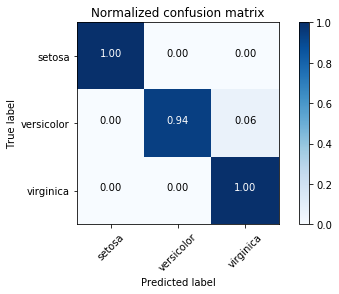

,setosa,versicolor,virginica
Precision,1.0,0.937500,1.000000
Recall,1.0,1.000000,0.900000
F1 measure,1.0,0.967742,0.947368


In [73]:
logreg = linear_model.LogisticRegression(C=1e5)
df_logreg = fit_model_iris(logreg)
df_logreg

Посмотрев на цифры выше можно сказать, что построенная модель отлично справляется с поставленной задаей классификациии. По одному из классов выходит стопроцентная детекция, по другим же она не меньше 90%. F-мера же не выходит ниже 94%. Уже по одной только этой моделе можно говорить, что она отлично обощает данные.

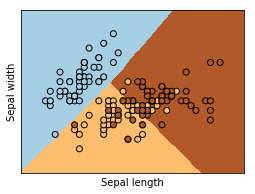

In [45]:
# урезали код
# модель линейной регресии для двух атрибутов

### Деревья решений

Следующей моделью, которую мы рассмотрим будут разрешающие деревья ([Decision Tree](https://en.wikipedia.org/wiki/Decision_tree), деревья решений). Чтоб понять этот метод, представим себе обычное бинарное дерево, где есть строгий выбор перехода на следующую ступень дерева. Т.е. мы задаем просто какие-то ветвления, посредством коротых, конечно, можем покрыть все возможные случаи. Встает сразу несколько важных вопросов: как принимать условия для ветвления? до какой глубины опускаться? Второй вопрос является очень важным. Если обучаться на одной выборке, то можно легко добиться точности в 100%, когда глубина дерева составляла бы $N-1$ состояний. Но тогда, скорее всего, на тестовой выборке мы получили бы плохой результат. Данный случай называется переобучением ([overfitting](https://en.wikipedia.org/wiki/Overfitting)), когда мы слишком "подгоняемся" под одну выборку, но обобщающей способностью наша модель почти не будет обладать. Поэтому один из гиперпараметров модели является максимальная глубина ($max$_$depth$).  Теперь подумаем, как мы будем определять ветвления (какие условия и какие значения при условиях). Обычно используеться несколько мер. Например, [Gini impurity](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity), не путать с коэф. Gini, которых характеризует примесь наших данных (грубо говоря, какова вероятность правильно угадать наш класс, при таком разбиении). Например, мы имеем при каком-то разбиении три класса, каждый из которых встретится со своей веростностью (вероятность считаем только для этого разбиения, т.е. в данном случае прикинем как отношение количества элементов этой группы ко всей выборке при таком разбиении). Тогда сумма произведений веростности для каждого класса (учитываем вероятность попадания и промаха) и будет составлять нашу $Gini$ $impurity$. Другой вариант - использование [Information gain](https://en.wikipedia.org/wiki/Information_gain_in_decision_trees), который характеризует количественную меру информации для какого-то определенного класса, т.е. с какой силой мы можем говорить о пренадлежности к какому-то из классов (аналог можно найти в [t-SNE](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)). Как видим, при выборе разбиения мы должны выбирать: по какому из атрибутов будем выделять группы. Для этого задается еще один гиперпараметр $max$_$features$.  
Аналогично логистической регресси оценим реузультат на кросс-валидации.

In [6]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import numpy as np
clf = DecisionTreeClassifier(random_state=0)
iris = load_iris()
np.mean(cross_val_score(clf, iris.data, iris.target, cv=5))

0.96000000000000019

Выходит, что "из коробки" решающие деревья показали жаэе более хороший результат, чем логистическая регрессия.  
Делим на тестовую и обучающую выборку со соотношением 70 на 30.

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=.33)

Посредством кросс-валидации можно находить оптимальные значения для гиперпараметров нашей модели (перебираются все случаи, для каждого из которых прикидывается свое значение кросс-валидации и наибольшее значение будет соответствовать лучшему случаю). В нашем случае будем перебирвать максимальную глубину дерева ($max$_$depth$) и количество атрибутов, по которым будем вести разбиение ($max$_$features$). 

In [21]:
from sklearn.model_selection import GridSearchCV
forest_params = {'max_depth': range(1,14), # глубину перебираем от 1 до 14
'max_features': range(1,5)} # количество атрибутов берем от 1 до 5
tree_grid = GridSearchCV(clf, forest_params,
cv=5, n_jobs=-1,
verbose=True)
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 52 candidates, totalling 260 fits


[Parallel(n_jobs=-1)]: Done 260 out of 260 | elapsed:    0.1s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(1, 14), 'max_features': range(1, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

In [22]:
tree_grid.best_estimator_ # получаем значение параметров для лучшей модели

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

Как видим, получили максимальную глубину и количество отрибтуов при разбиении равными двум для оптимального случая. Построим полученную модель и сравним с логистической регрессией.

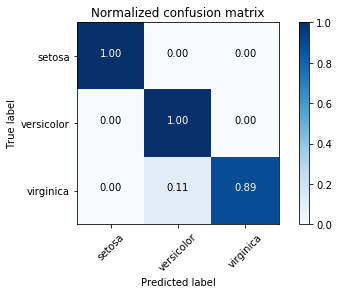

,setosa,versicolor,virginica
Precision,1.0,1.000000,0.888889
Recall,1.0,0.941176,1.000000
F1 measure,1.0,0.969697,0.941176


In [79]:
clf = DecisionTreeClassifier(random_state=0, max_features=2, max_depth=2)
df_tree = fit_model_iris(clf)
df_tree

Как видим, по цифрам все вышло немного хуже, чем для логистичесой регрессии, хотя все равно результаты очень и очень хорошие (конечно, все дело в очень удачной выборке). Ради интереса можем еще построить само дерево решений, по которому все строит наша модель. Для этого есть специальная утилита graphiz в Питоне.  

![Graph](https://pp.userapi.com/c841624/v841624903/3631b/WD_2zN-HSBE.jpg)

Как видим, на каждом лепестпе можем посмотреть значение то, по какому признаку идет разбиение и при каком значении (самый верх), а также $Gini$ (Gini impurity). Значение $samples$ показывает, сколько осталось в общей выбрке. Значение $value$ отражает, сколько осталось по каждому классу. Для интереса приведем картинку для случая, когда было бы переобучение, т.е. когда бы мы взялима максимальную глубину и "подогнались" бы под всю выборку. Переобучение является серьезной проблемой для деревьев решений. Для борьбы с этим используют [случайный лес](https://www.google.ru/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&ved=0ahUKEwjB2uzMrKfXAhUjJ5oKHQ8uD8wQFggnMAA&url=https%3A%2F%2Fru.wikipedia.org%2Fwiki%2FRandom_forest&usg=AOvVaw0OOhfoOzsrok1ODyf-jO-I) (набор разных деревьев решений с разными параметрами). 

![Graph](http://scikit-learn.org/stable/_images/iris.svg)

### SVC

SVC (support vector classifier) - алгоритм классификации, основанный на SVM ([support vector machine](https://en.wikipedia.org/wiki/Support_vector_machine)) методе опорных векторов. Аналогично логистической регрессии, мы рассматриваем случай, когда у нас есть разделяющая прямая, которая задается вектором $w$. Посотроим резделяющую прямую таким образом, чтобы она была между нашими классами на одинаковом расстоянии. Легко доказывается, что это расстояние будет составлять $2/||w||$. Для выбора функционала для задачи классификации используется ([soft-margin])(https://en.wikipedia.org/wiki/Support_vector_machine), который определяется как cумма отклонений наших ошибок в классификации (берем либо ноль, либо значение ошибки). Если внимательно посмотреть на выражение soft-margin, то заметная еще правая часть с модулем вектора, коэф. при котором отвечает за чувствительность к ошибкам (линейно зависит от коэфа. регуляризации (если будет необходимость, то можем подробнее про это написать)).

In [82]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn import svm
import numpy as np
clf = svm.SVC(kernel='linear', C=1)
iris = load_iris()
np.mean(cross_val_score(clf, iris.data, iris.target, cv=5))

0.98000000000000009

Как видим, в обычном случае мы получили еще больший результат, чем раньше. Тут мы задали гиперпараметр $kernel$ - ядро. Немного подробнее опишем, что это и для чего. Ядро ($kernel$ $trick$) позволяет перевести наши данные в новое пространство с изменением зависимости между данными. Обычно это рассматривается на примере, когда у нас данные распределены по каким-то окружностям, тогда обычный SVM не даст адекватного результата, т.к. он для линейных моделей используется, однако, при использовании нелинйеного ядра (скажем, грубо говоря замена одной из оси на квадрат сумму осей ранних) мы получим линейную зависимость (теперь одна из осей будет отвечать за расстояние от центра по сфере). Продемонстрируем, как менялись бы случаи при разных ядрах. 

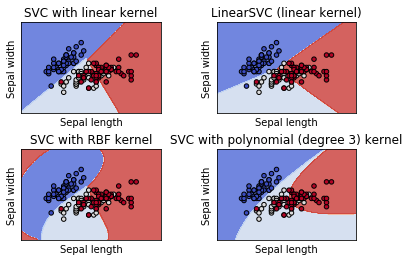

In [84]:
# тут урезали код для выбора разных ядер

Очевидно, что для нашего случая лучше всего подходит линейно ядро. Поэтому и используем данное ядро. Теперь числно посмотрем на классификацию этой модели.

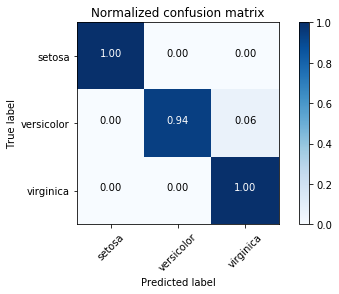

,setosa,versicolor,virginica
Precision,1.0,0.937500,1.000000
Recall,1.0,1.000000,0.900000
F1 measure,1.0,0.967742,0.947368


In [85]:
clf = clf = svm.SVC(kernel='linear', C=1)
df_svc = fit_model_iris(clf)
df_svc

Как видим, результат получился аналогично случаю с логистической регрессией, что объясняется похожим подходом (линейные модели).

### CatBoost

Рассмотрим градиентный бустинг от Яндекса. Утверждается, что он показывает себя [лучше](https://catboost.yandex/#benchmark), чем такие мощные модели, как XGBoost, которые зачастую считаются универсальным инструентом для решения задач ML.

In [89]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(['target'], axis=1), df['target'], test_size=0.33)

In [90]:
from catboost import Pool
cat_features = []
p = Pool(X_train, y_train, cat_features) # задаем пулл для данных (специфично для CatBoost) 

In [91]:
%%time
from catboost import CatBoost
cat_boost = CatBoost()
cat_boost.fit(p)

CPU times: user 8.76 s, sys: 1.34 s, total: 10.1 s
Wall time: 3.48 s


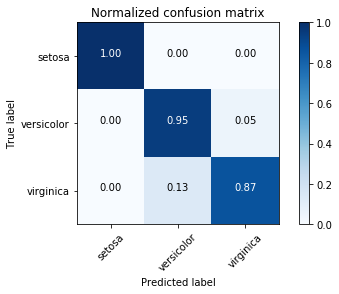

In [92]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=.33)

cat_features = []
p = Pool(X_train, y_train, cat_features)
cat_boost = CatBoost()
cat_boost.fit(p)
test = Pool(X_test, cat_features=cat_features)
y_pred = [round(x) for x in cat_boost.predict(test)]
y_test = list(y_test)

# урезам часть кода, т.к. он аналогичен тому, что мы смотрели раннее

In [93]:
precision = pd.Series()
recall = pd.Series()
f1 = pd.Series()

for i in range(len(cnf_matrix)):
    precision = precision.append(pd.Series(cnf_matrix[i][i] / sum(cnf_matrix[i]), index=[i]))

tran_cnf_matrix = numpy.transpose(cnf_matrix)
for i in range(len(tran_cnf_matrix)):
    recall = recall.append(pd.Series(tran_cnf_matrix[i][i] / sum(tran_cnf_matrix[i]), index=[i]))

for i, _ in recall.iteritems():
        f1 = f1.append(pd.Series(2*precision.iloc[i]*recall.iloc[i]/(precision.iloc[i]+recall.iloc[i]), index=[i]))
    
df_cat = pd.DataFrame([precision, recall, f1])
df_cat.columns = class_names
df_cat.index = ['Precision', 'Recall', 'F1 measure']

In [94]:
df_cat

,setosa,versicolor,virginica
Precision,1.0,0.947368,0.866667
Recall,1.0,0.900000,0.928571
F1 measure,1.0,0.923077,0.896552


Так получилось, что применительно к нашей задаче, $CatBoost$ взял лучшее и худшее от описанных выше моделей (можно оценить по матрице ошибок). Отметим, что F1 мера все еще показывает очень высокий показатель. Из этого можно сделать, что применительно градиентный бустинг не является панацеей. 

## Что рассмтрим дальше


Планируется рассмотреть алгоритмы кластеризации. И подойти уже к настройке нейронной сети для классификации картинок.